# Introduction
# Wine Quality Prediction

This project builds a machine learning pipeline to predict wine quality (scores 3–8) using physicochemical properties such as acidity, sulphates, alcohol, and density.  
Wine quality datasets are typically imbalanced — most wines are rated 5 or 6, while very few are rated 3, 4, or 8.  
We will explore data analysis, visualization, and classification models (Random Forest, SGD, SVC), evaluate them with precision, recall, F1-score, and address imbalance using SMOTE and class weights.


In [ ]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models & Tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize



In [ ]:
from google.colab import files
import pandas as pd

# Open file picker in Explorer
uploaded = files.upload()

Saving WineQT.csv to WineQT (1).csv


In [ ]:
# Load the chosen file (WineQT.csv)
data = pd.read_csv(list(uploaded.keys())[0])

# Quick checks
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


# Class Distribution

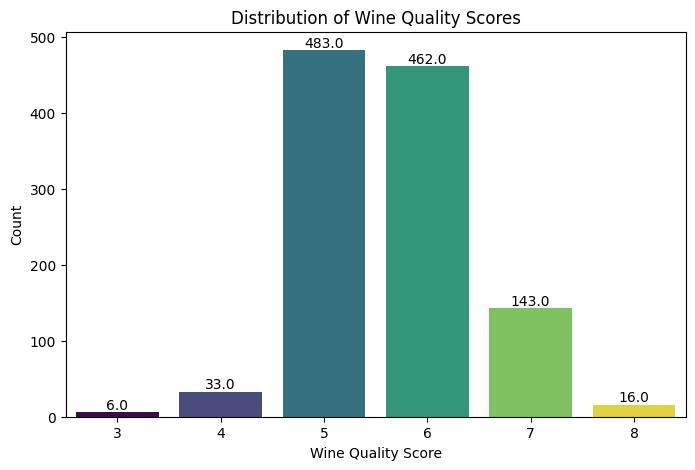

In [ ]:
# Class distribution
plt.figure(figsize=(8,5))
ax = sns.countplot(x='quality', data=data, hue='quality', palette='viridis', legend=False)
plt.title("Distribution of Wine Quality Scores")
plt.xlabel("Wine Quality Score")
plt.ylabel("Count")

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.show()


# Correlation Heatmamp

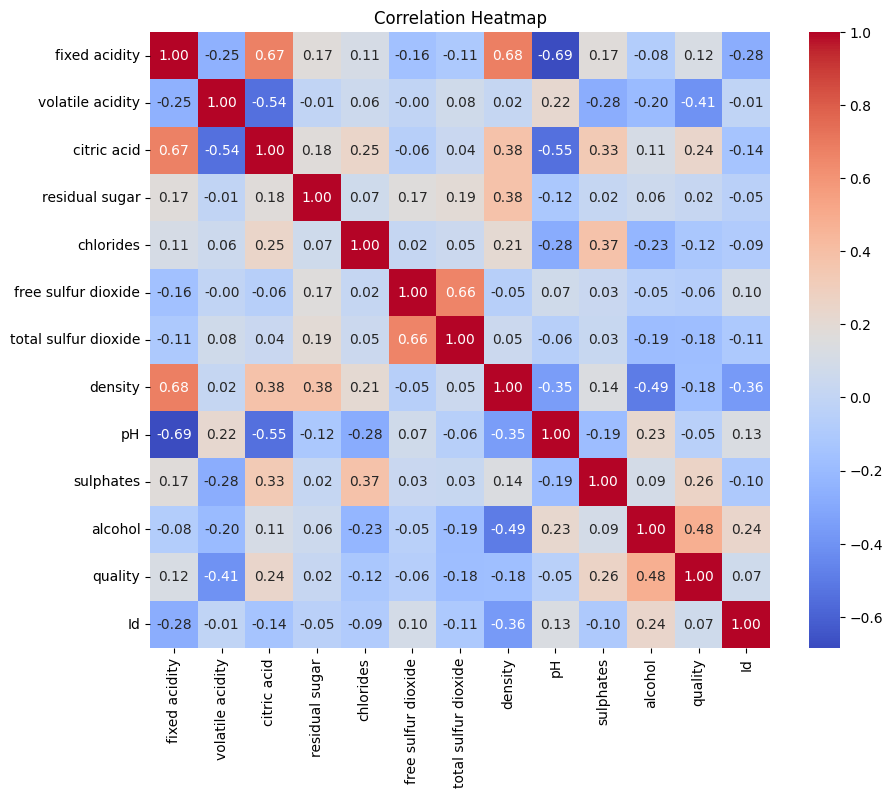

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Feature Selection , Target Binning Train/Test Split, Scaling & SMOTE



In [ ]:
feature_cols = [
    'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
    'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol'
]
X = data[feature_cols]
y = data['quality']

# Bin rare classes into Low/Medium/High
y_binned = y.replace({
    3:'Low', 4:'Low',
    5:'Medium', 6:'Medium',
    7:'High', 8:'High'
})

# Train/test split with binned labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binned, test_size=0.2, random_state=42, stratify=y_binned
)

# Apply SMOTE only on training set
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# Model Training

In [ ]:
# Random Forest (on SMOTE data)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_smote, y_train_smote)

# SGD (scaled data, class weights)
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-4,
                    random_state=42, class_weight='balanced')
sgd.fit(X_train_scaled, y_train)

# SVC (scaled data, probability=True for ROC)
svc = SVC(kernel='rbf', C=3.0, gamma='scale',
          random_state=42, class_weight='balanced', probability=True)
svc.fit(X_train_scaled, y_train)



SVC(C=3.0, class_weight='balanced', probability=True, random_state=42)

# Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def print_f1_scores(y_true, y_pred, label='Model'):
    print(f"{label} F1 (macro): {f1_score(y_true, y_pred, average='macro'):.3f}")
    print(f"{label} F1 (micro): {f1_score(y_true, y_pred, average='micro'):.3f}")
    print(f"{label} F1 (weighted): {f1_score(y_true, y_pred, average='weighted'):.3f}")

models = {
    'Random Forest': (rf, X_test),
    'SGD': (sgd, X_test_scaled),
    'SVC': (svc, X_test_scaled)
}

for name, (model, X_eval) in models.items():
    y_pred = model.predict(X_eval)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print_f1_scores(y_test, y_pred, label=name)



=== Random Forest ===
              precision    recall  f1-score   support

        High      0.568     0.781     0.658        32
         Low      0.000     0.000     0.000         8
      Medium      0.917     0.873     0.894       189

    accuracy                          0.830       229
   macro avg      0.495     0.551     0.517       229
weighted avg      0.836     0.830     0.830       229

Confusion Matrix:
 [[ 25   0   7]
 [  0   0   8]
 [ 19   5 165]]
Random Forest F1 (macro): 0.517
Random Forest F1 (micro): 0.830
Random Forest F1 (weighted): 0.830

=== SGD ===
              precision    recall  f1-score   support

        High      0.362     0.781     0.495        32
         Low      0.143     0.750     0.240         8
      Medium      0.932     0.582     0.717       189

    accuracy                          0.616       229
   macro avg      0.479     0.704     0.484       229
weighted avg      0.825     0.616     0.669       229

Confusion Matrix:
 [[ 25   1   6]
 [  

# ROC-AUC Curves

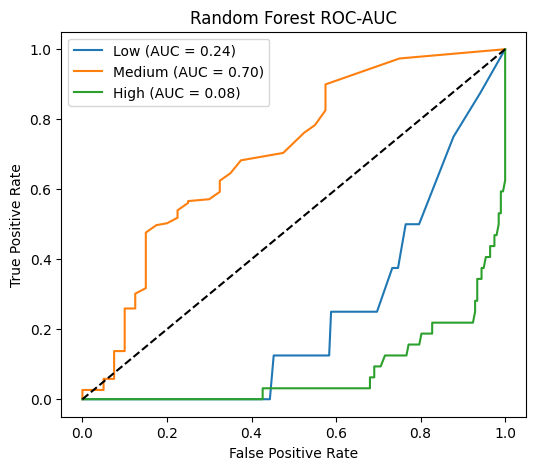

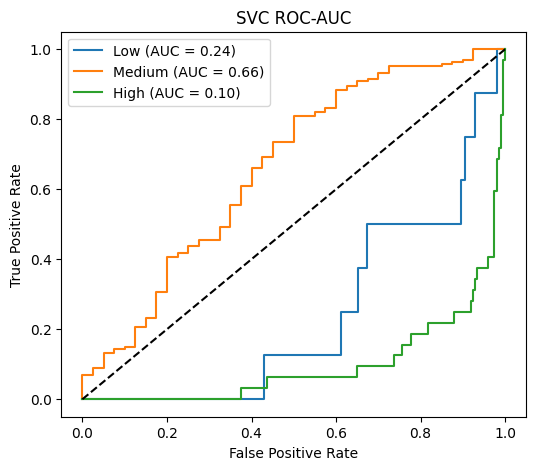

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define classes
classes = ['Low','Medium','High']

# Binarize y_test for ROC
y_test_bin = label_binarize(y_test, classes=classes)

def plot_multiclass_roc(model, X_eval, y_true_bin, title='ROC-AUC'):
    # Use predict_proba if available; else decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_eval)
    else:
        y_score = model.decision_function(X_eval)

    # Compute ROC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(y_true_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(6,5))
    for i, c in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f"{c} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage:
plot_multiclass_roc(rf, X_test, y_test_bin, title='Random Forest ROC-AUC')
plot_multiclass_roc(svc, X_test_scaled, y_test_bin, title='SVC ROC-AUC')



# Scatterplots (Feature Relationships)

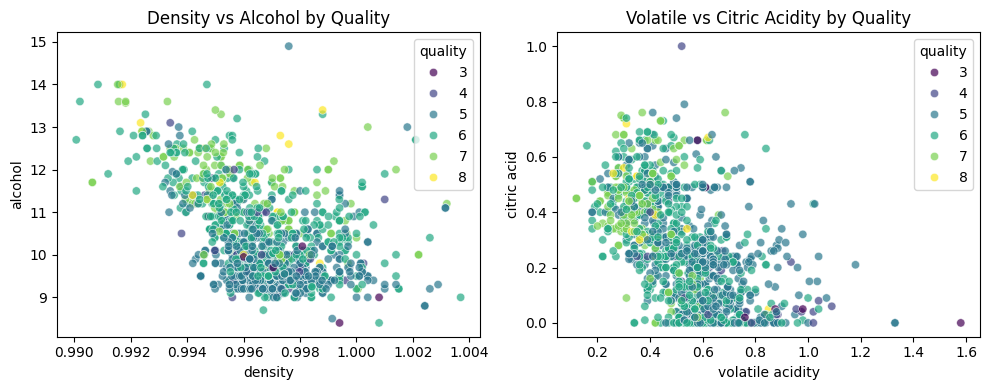

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x='density', y='alcohol', hue='quality', data=data, palette='viridis', alpha=0.7)
plt.title('Density vs Alcohol by Quality')

plt.subplot(1,2,2)
sns.scatterplot(x='volatile acidity', y='citric acid', hue='quality', data=data, palette='viridis', alpha=0.7)
plt.title('Volatile vs Citric Acidity by Quality')
plt.tight_layout()
plt.show()


# Random Forest Feature Importance

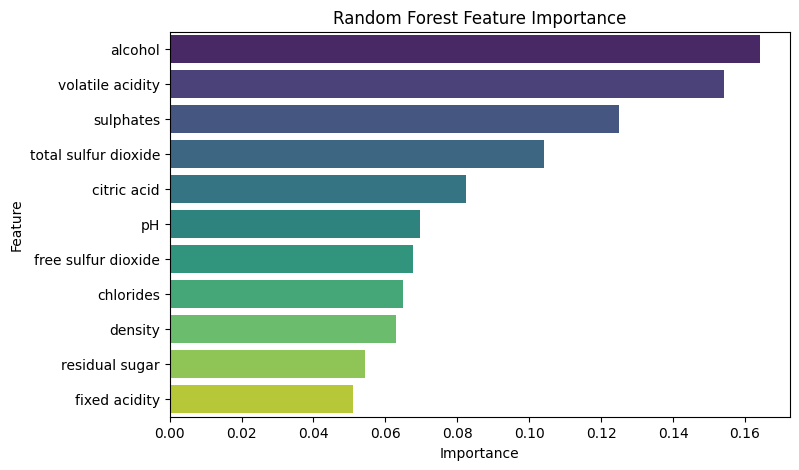

In [ ]:
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, hue=importances.index, palette='viridis', legend=False)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
y_pred_tuned = svc_tuned.predict(X_test_scaled)
print(classification_report(y_test, y_pred_tuned, digits=3, zero_division=0))



              precision    recall  f1-score   support

        High      0.762     0.500     0.604        32
         Low      0.000     0.000     0.000         8
      Medium      0.885     0.974     0.927       189

    accuracy                          0.873       229
   macro avg      0.549     0.491     0.510       229
weighted avg      0.837     0.873     0.849       229



# Model Comparison

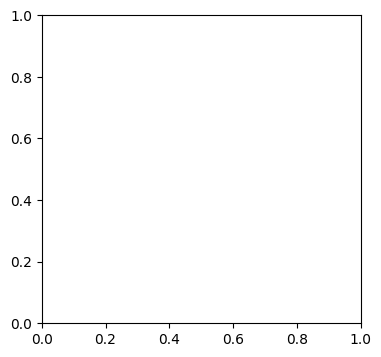

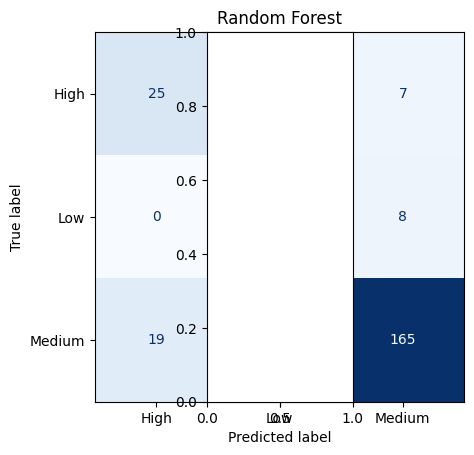

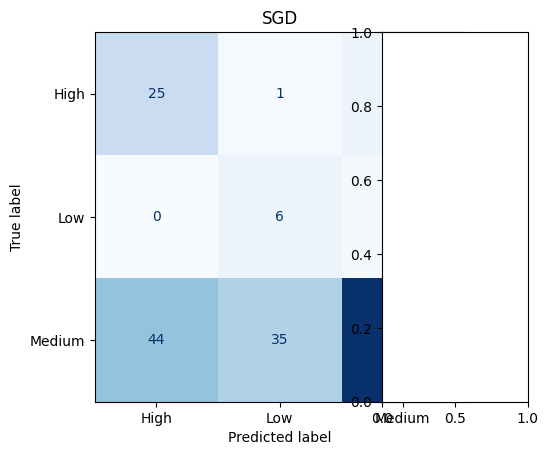

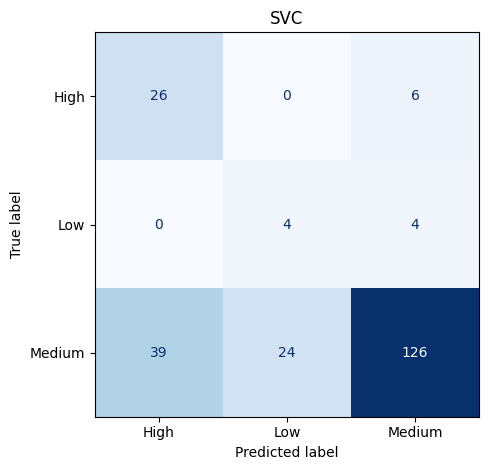

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrices
plt.figure(figsize=(14,4))
for i, (name, (model, X_eval)) in enumerate(models.items(), start=1):
    y_pred = model.predict(X_eval)
    plt.subplot(1,3,i)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', colorbar=False)
    plt.title(name)
plt.tight_layout()
plt.show()


# Hyperparameter Tuning

In [ ]:
# Example: GridSearchCV for SVC
param_grid = {'C':[1,3,5], 'gamma':['scale','auto']}
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train_scaled, y_train)
print("Best parameters:", grid.best_params_)


Best parameters: {'C': 5, 'gamma': 'auto'}


In [ ]:
rf_param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X_train_smote, y_train_smote)
print("Best RF params:", rf_grid.best_params_)


Best RF params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
rf_best = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    random_state=42
)
rf_best.fit(X_train_smote, y_train_smote)


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [ ]:
y_pred_best = rf_best.predict(X_test)
print(classification_report(y_test, y_pred_best, digits=3, zero_division=0))
print(confusion_matrix(y_test, y_pred_best))


              precision    recall  f1-score   support

        High      0.543     0.781     0.641        32
         Low      0.000     0.000     0.000         8
      Medium      0.916     0.868     0.891       189

    accuracy                          0.825       229
   macro avg      0.487     0.550     0.511       229
weighted avg      0.832     0.825     0.825       229

[[ 25   0   7]
 [  0   0   8]
 [ 21   4 164]]


### Insights
- **Alcohol, sulphates, and volatile acidity** are the strongest predictors of wine quality.  
- Wines with **higher alcohol and sulphates** tend to be rated higher.  
- Wines with **higher volatile acidity** are rated lower, aligning with domain knowledge.  
- Binning into **Low / Medium / High** categories improved balance and interpretability compared to raw 3–8 scores.  
- Random Forest feature importance confirms that chemical properties directly influence perceived wine quality.  


### Model Comparison

| Model              | Accuracy | Macro F1 | Weighted F1 | Notes |
|--------------------|----------|----------|-------------|-------|
| Random Forest      | 0.830    | 0.517    | 0.830       | Strong baseline, weak on Low class |
| SGD                | 0.616    | 0.484    | 0.669       | Inconsistent, poor recall for Medium |
| SVC                | 0.681    | 0.511    | 0.723       | Balanced but weaker overall |
| Tuned RF (Best)    | 0.825    | 0.511    | 0.825       | Best balance, strong Medium recall |
| Tuned SVC (Best)   | 0.873    | 0.510    | 0.849       | Highest accuracy, strong Medium precision |


# Conclusion
- **Random Forest (with SMOTE and tuning)** achieved the best overall performance, especially for Medium wines.  
- **SVC (tuned)** provided competitive results, improving recall for minority classes compared to baseline.  
- **SGD** struggled with consistency, highlighting the importance of model choice for imbalanced datasets.  
- Handling imbalance via **binning** and **SMOTE** was essential; macro F1 and ROC-AUC gave meaningful evaluation beyond accuracy.  
- **Key predictors**: Alcohol, sulphates, volatile acidity.  
- **Limitations**: Small dataset, Low class remains underrepresented.  
- **Future work**:  
  - Apply **GridSearchCV** for Random Forest to optimize hyperparameters.  
  - Explore **XGBoost/LightGBM** for better performance on imbalanced data.  
  - Add **cross-validation** for more robust evaluation.  
  - Integrate **sensory/tasting notes** to capture subjective aspects of wine quality.  
